# Data Representation

### Scaling helps

#### WHY SCALE NUMERIC VALUES TO LIE IN [–1, 1]?
Gradient descent optimizers require more steps to converge as the curvature of the loss function increases. This is because the derivatives of features with larger relative magnitudes will tend to be larger as well, and so lead to abnormal weight updates. The abnormally large weight updates will require more steps to converge and thereby increase the computation load.\
“Centering” the data to lie in the [–1, 1] range makes the error function more spherical. Therefore, models trained with transformed data tend to converge faster and are therefore faster/cheaper to train. In addition, the [–1, 1] range offers the highest floating point precision.

In [2]:
from sklearn import datasets, linear_model
import timeit

diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
raw = diabetes_X[:, None, 2]
max_raw = max(raw)
min_raw = min(raw)
scaled = (2*raw - max_raw - min_raw)/(max_raw - min_raw)

def train_raw():
    linear_model.LinearRegression().fit(raw, diabetes_y)

def train_scaled():
    linear_model.LinearRegression().fit(scaled, diabetes_y)

import timeit
raw_time = timeit.timeit(train_raw, number=1000)
scaled_time = timeit.timeit(train_scaled, number=1000)
print('Raw: {:.4f}s, Scaled: {:.4f}s, Improvement: {:2f}%'
      .format(raw_time, scaled_time, 100*(raw_time-scaled_time)/raw_time))

Raw: 0.2404s, Scaled: 0.2061s, Improvement: 14.269567%


____

## Numerical inputs

In [3]:
import numpy as np
import pandas as pd

s = np.random.uniform(4, 100, size=1000)
n = np.random.uniform(-20, -10, size=5)

s = np.append(s, n)

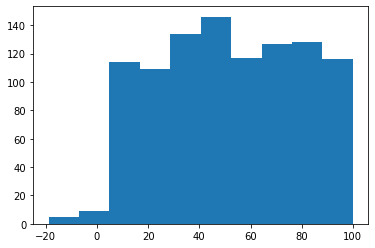

In [4]:
import matplotlib.pyplot as plt
plt.hist(s);

### Linear

Min max

In [5]:
from sklearn.preprocessing import MinMaxScaler
s_min_max = MinMaxScaler().fit_transform(s.reshape(-1,1))

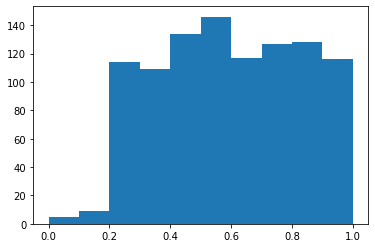

In [6]:
plt.hist(s_min_max);

Clipping -> min-max

In [7]:
vmax = 100
vmin = 0
s_clipping = pd.Series(s).apply(lambda x: vmax if x > vmax else vmin if x < vmin else x)
s_clipping = MinMaxScaler(clip=True).fit_transform(np.array(s_clipping).reshape(-1, 1))

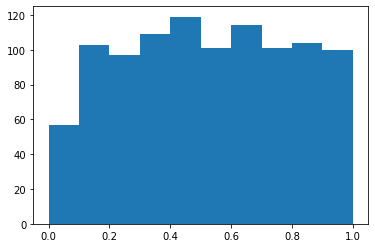

In [8]:
plt.hist(s_clipping);

Z_norm

In [9]:
from sklearn.preprocessing import StandardScaler
s_z = StandardScaler().fit_transform(s.reshape(-1,1))

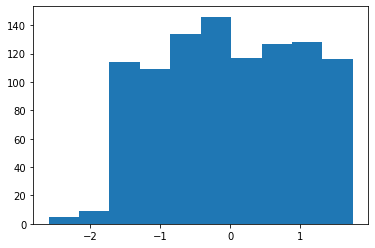

In [10]:
plt.hist(s_z);

Winsorizing

In [11]:
from sklearn.preprocessing import RobustScaler
s_win = RobustScaler(quantile_range=(25, 75)).fit_transform(s.reshape(-1,1))

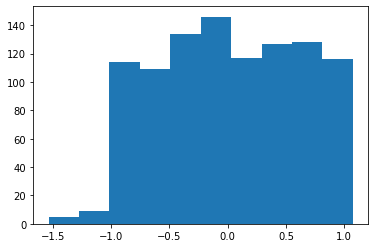

In [12]:
plt.hist(s_win);

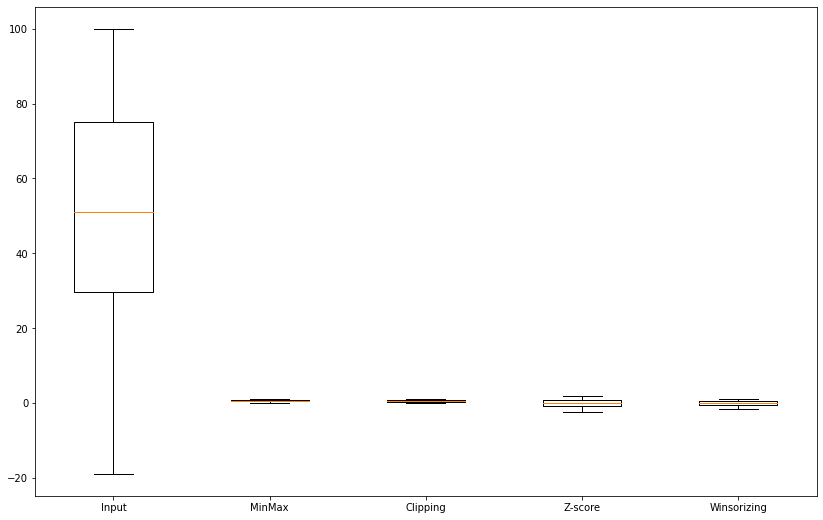

In [13]:
vals = [s.flatten(), s_min_max.flatten(), s_clipping.flatten(), s_z.flatten(), s_win.flatten()]
labels = ['Input', 'MinMax', 'Clipping', 'Z-score', 'Winsorizing']

plt.figure(figsize=(14,9))
plt.boxplot(vals, labels=labels);

### Nonlinear

Logarithm

In [14]:
import warnings
warnings.filterwarnings('ignore')
s_log = pd.Series(s).apply(lambda x: np.log(x) if x != 0 else 0)

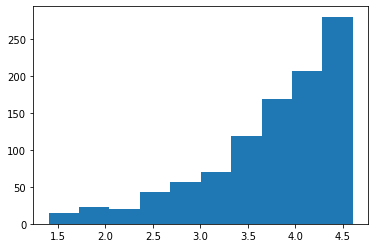

In [15]:
plt.hist(s_log);

Sigmoid

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

s_sig = sigmoid(s)

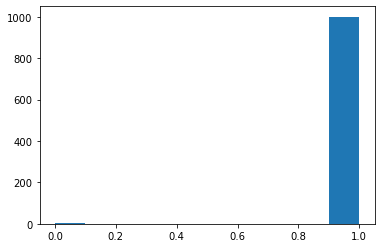

In [18]:
plt.hist(s_sig);

Normalization

In [19]:
from sklearn.preprocessing import Normalizer
s_norm = Normalizer().fit_transform(s.reshape(-1,1))

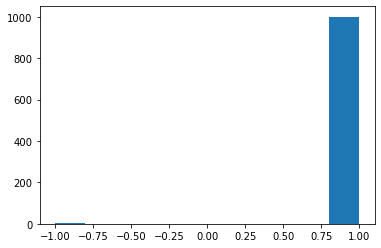

In [20]:
plt.hist(s_norm);

Square root

In [21]:
s_square = np.sqrt(s)

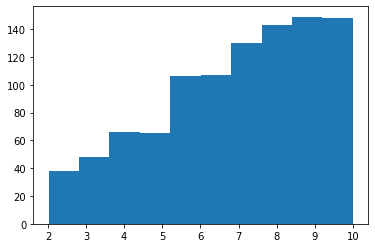

In [22]:
plt.hist(s_square);

Box-cox

In [23]:
from sklearn.preprocessing import PowerTransformer
#only for positive data
s_ = pd.Series(s).apply(lambda x: x if x > 0 else 1)
s_boxcox = PowerTransformer(method='box-cox').fit_transform(np.array(s_).reshape(-1,1))

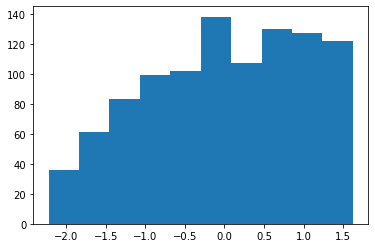

In [24]:
plt.hist(s_boxcox);

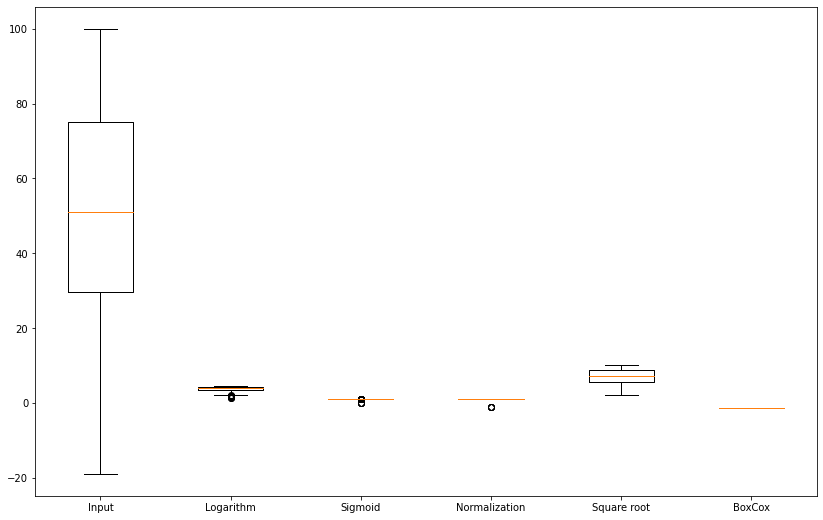

In [25]:
vals = [s, s_log[~s_log.isna()], s_sig, s_norm, s_square[~np.isnan(s_square)], s_boxcox[0]]
labels = ['Input', 'Logarithm', 'Sigmoid', 'Normalization', 'Square root', 'BoxCox']

plt.figure(figsize=(14,9))
plt.boxplot(vals, labels=labels);

## Categorical inputs

Label or Ordinal encoder

In [26]:
from sklearn.preprocessing import OrdinalEncoder

train_df = pd.DataFrame({'Degree':['High school', 'Masters', 'Diploma',
                                   'Bachelors', 'Bachelors', 'Masters', 'Phd',
                                   'High school', 'High school']})
enc = OrdinalEncoder()
train_enc = pd.Series(enc.fit_transform(train_df)[:, 0], name='Degree_ord_enc')
pd.concat([train_df, train_enc], axis=1)

,Degree,Degree_ord_enc
0,High school,2.0
1,Masters,3.0
2,Diploma,1.0
3,Bachelors,0.0
4,Bachelors,0.0
5,Masters,3.0
6,Phd,4.0
7,High school,2.0
8,High school,2.0


One hot encoder

In [27]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe_df = ohe.fit_transform(train_df["Degree"].values.reshape(-1, 1))

train_df_encoded = pd.DataFrame(ohe_df.toarray())
train_df_encoded.columns = 'Degree_' + ohe.categories_[0]

In [28]:
pd.concat([train_df, train_df_encoded], axis=1)

,Degree,Degree_Bachelors,Degree_Diploma,Degree_High school,Degree_Masters,Degree_Phd
0,High school,0.0,0.0,1.0,0.0,0.0
1,Masters,0.0,0.0,0.0,1.0,0.0
2,Diploma,0.0,1.0,0.0,0.0,0.0
3,Bachelors,1.0,0.0,0.0,0.0,0.0
4,Bachelors,1.0,0.0,0.0,0.0,0.0
5,Masters,0.0,0.0,0.0,1.0,0.0
6,Phd,0.0,0.0,0.0,0.0,1.0
7,High school,0.0,0.0,1.0,0.0,0.0
8,High school,0.0,0.0,1.0,0.0,0.0


Dummy encoding

In [29]:
dum_df = pd.get_dummies(train_df, drop_first=True, columns=["Degree"], prefix=["Degree"])
train_df.join(dum_df)

,Degree,Degree_Diploma,Degree_High school,Degree_Masters,Degree_Phd
0,High school,0,1,0,0
1,Masters,0,0,1,0
2,Diploma,1,0,0,0
3,Bachelors,0,0,0,0
4,Bachelors,0,0,0,0
5,Masters,0,0,1,0
6,Phd,0,0,0,1
7,High school,0,1,0,0
8,High school,0,1,0,0


In [31]:
pip install category_encoders

     |████████████████████████████████| 80 kB 310 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Count encoding

In [37]:
import category_encoders.count as ce
coe = ce.CountEncoder()
train_enc = coe.fit_transform(train_df["Degree"]).rename(columns={"Degree": "Degree_count_enc"})
pd.concat([train_df, train_enc], axis=1)

,Degree,Degree_count_enc
0,High school,3
1,Masters,2
2,Diploma,1
3,Bachelors,2
4,Bachelors,2
5,Masters,2
6,Phd,1
7,High school,3
8,High school,3


Relative frequency encoding

In [39]:
import category_encoders.count as ce
coe = ce.CountEncoder()
train_enc = coe.fit_transform(train_df["Degree"])\
            .rename(columns={"Degree": "Degree_count_enc"}) / train_df["Degree"].nunique()
pd.concat([train_df, train_enc], axis=1)

,Degree,Degree_count_enc
0,High school,0.6
1,Masters,0.4
2,Diploma,0.2
3,Bachelors,0.4
4,Bachelors,0.4
5,Masters,0.4
6,Phd,0.2
7,High school,0.6
8,High school,0.6
